# AI-based OCR Benchmark Notebook

This notebook benchmarks **AI-based OCR models** on scanned PDF documents/images in Spanish.
It excludes traditional OCR engines like Tesseract that require external installations.

In [1]:
%pip install --upgrade pip
%pip install --upgrade jupyter
%pip install --upgrade ipywidgets
%pip install --upgrade ipykernel

# Install necessary packages
%pip install transformers torch pdf2image pillow jiwer paddleocr hf_xet paddlepaddle
# pdf reading
%pip install PyMuPDF

# Data analysis and visualization
%pip install pandas
%pip install matplotlib
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https:/

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageOps
import torch
from jiwer import wer, cer
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
import re
from datetime import datetime

## 1 Configuration

In [3]:
PDF_FOLDER = './instructions'  # Folder containing PDF files
OUTPUT_FOLDER = 'results'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [4]:
# 3. PaddleOCR 
# https://www.paddleocr.ai/v3.0.0/en/version3.x/pipeline_usage/OCR.html?utm_source=chatgpt.com#21-command-line
from paddleocr import PaddleOCR

# Initialize with better settings for Spanish/Latin text
# https://www.paddleocr.ai/main/en/version3.x/algorithm/PP-OCRv5/PP-OCRv5_multi_languages.html?utm_source=chatgpt.com#5-models-and-their-supported-languages
paddleocr_model = PaddleOCR(
    text_detection_model_name="PP-OCRv5_server_det",
    text_recognition_model_name="PP-OCRv5_server_rec",
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=True,
    lang='es',
)

C:\Users\sji\AppData\Local\Temp\ipykernel_5520\2286581791.py:7: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  paddleocr_model = PaddleOCR(
c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\sji\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\sji\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_

In [5]:
import paddleocr

print(paddleocr.__version__)

3.3.1


In [6]:
# 1) Dump the active paddlex pipeline config to a YAML file
yaml_path = "paddleocr_pipeline_dump.yaml"
paddleocr_model.export_paddlex_config_to_yaml(yaml_path)
print("Exported:", yaml_path)

Exported: paddleocr_pipeline_dump.yaml


In [7]:
# 1) Locate the installed PaddleOCR package
pkg_dir = os.path.dirname(paddleocr.__file__)
print(pkg_dir)

c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\paddleocr


## 2 Helper Functions

In [8]:
# preprocess_image.py
import cv2
import numpy as np

def preprocess_for_ocr(pil_image):
    """
    Preprocesamiento optimizado para PaddleOCR
    
    Args:
        pil_image (PIL.Image.Image): Imagen PIL
    
    Returns:
        PIL.Image.Image: Imagen preprocesada en formato RGB
    """
    
    # Convertir PIL Image a numpy array
    img_array = np.array(pil_image)
    
    # Si la imagen es RGBA, convertir a RGB
    if img_array.shape[-1] == 4:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    
    # Si la imagen es RGB, convertir a BGR para OpenCV
    if len(img_array.shape) == 3 and img_array.shape[-1] == 3:
        img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = img_array
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Upscaling si es necesario
    height, width = gray.shape
    if height < 1000:
        scale = 1500 / height
        new_width = int(width * scale)
        new_height = int(height * scale)
        gray = cv2.resize(gray, (new_width, new_height), 
                         interpolation=cv2.INTER_CUBIC)
    
    # Binarización adaptativa
    binary = cv2.adaptiveThreshold(
        gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 2
    )
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
    
    # Dilate
    kernel = np.ones((1,1), np.uint8)
    dilated = cv2.dilate(denoised, kernel, iterations=1)
    
    # Convertir a RGB
    rgb_img = cv2.cvtColor(dilated, cv2.COLOR_GRAY2RGB)
    
    # Convertir de vuelta a PIL Image
    pil_img = Image.fromarray(rgb_img)
    
    return pil_img  # PIL.Image.Image en modo RGB

In [9]:
from typing import List, Optional

def show_page(img: Image.Image, text: str,  scale: float = 1):
    """
    Displays a smaller version of the image with text as a footer.
    """
    # Compute plot size based on image dimensions (but without resizing the image)
    w, h = img.size
    figsize = (w * scale / 100, h * scale / 100)  # convert pixels to inches approx

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis("off")


    # Add OCR text below the image (footer)
    # plt.figtext(0.5, 0.02, text.strip(), wrap=True, ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def pdf_to_images(pdf_path: str, dpi: int = 300, pages: List[int] = None) -> List[Image.Image]:
    """
    Render a PDF into a list of PIL Images using PyMuPDF or pdf2image.
    'pages' is 1-based (e.g., range(1, 10) -> pages 1–9).
    """
    images = []

    if fitz is not None:
        doc = fitz.open(pdf_path)
        total_pages = len(doc)

        # Adjust page indices (PyMuPDF uses 0-based indexing)
        if pages is None:
            page_indices = list(range(total_pages))
        else:
            # Filter out invalid pages and convert to 0-based
            page_indices = [p - 1 for p in pages if 1 <= p <= total_pages]

        for i in page_indices:
            page = doc.load_page(i)
            mat = fitz.Matrix(dpi / 72.0, dpi / 72.0)
            pix = page.get_pixmap(matrix=mat, alpha=False)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            
            images.append(img)
        doc.close()
    else:
        raise RuntimeError("Install PyMuPDF or pdf2image to convert PDFs.")

    return images

def pdf_extract_text(pdf_path, page_num, line_tolerance=15) -> str:
    """
    Extracts text from a specific PDF page in proper reading order.
    Adds '\n' when blocks are vertically separated more than line_tolerance.
    Removes bullet-like characters (, •, ▪, etc.).
    """
    doc = fitz.open(pdf_path)

    if page_num < 1 or page_num > len(doc):
        return ""

    page = doc[page_num - 1]
    blocks = page.get_text("blocks")  # (x0, y0, x1, y1, text, block_no, block_type)

    # Sort blocks: top-to-bottom, left-to-right
    blocks_sorted = sorted(blocks, key=lambda b: (b[1], b[0]))

    text_lines = []
    last_y = None

    for b in blocks_sorted:
        y0 = b[1]
        text_block = b[4].strip()

        # Remove bullet-like characters
        text_block = re.sub(r"[•▪◦●❖▶■]", "", text_block)

        # If new line (based on vertical gap)
        if last_y is not None and abs(y0 - last_y) > line_tolerance:
            text_lines.append("")  # blank line for spacing

        text_lines.append(text_block.strip())
        last_y = y0

    # Join all lines with real newlines
    text = "\n".join(text_lines)

    # Normalize spaces
    text = re.sub(r"\s*\n\s*", "\n", text).strip()   # remove spaces around newlines
    text = re.sub(r" +", " ", text).strip()          # collapse multiple spaces to one
    text = re.sub(r"\n{3,}", "\n\n", text).strip()   # avoid triple blank lines

    doc.close()
    return text

def evaluate_text(reference, prediction):
    return {'WER': wer(reference, prediction), 'CER': cer(reference, prediction)}

## 3 Model wrapers

In [10]:
import numpy as np
import re

def _normalize_box_xyxy(box):
    """
    Accepts:
      - [[x,y],[x,y],[x,y],[x,y]]   (quad)
      - [x0, y0, x1, y1]            (flat)
      - [x0, y0, x1, y1, x2, y2, x3, y3] (flat quad)
    Returns (x0, y0, x1, y1)
    """
    # Quad as list of points?
    if isinstance(box, (list, tuple)) and box and isinstance(box[0], (list, tuple)):
        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        return min(xs), min(ys), max(xs), max(ys)

    # Flat list
    if isinstance(box, (list, tuple)):
        if len(box) == 4:
            x0, y0, x1, y1 = box
            # ensure order
            return min(x0, x1), min(y0, y1), max(x0, x1), max(y0, y1)
        if len(box) == 8:
            xs = box[0::2]
            ys = box[1::2]
            return min(xs), min(ys), max(xs), max(ys)

    # Fallback
    raise ValueError(f"Unrecognized box format: {box!r}")

def ocr_paddle(img, image_array, min_score=0.0, line_tol_factor=0.6):
    """
    Robust line grouping for PaddleOCR outputs:
    - normalizes boxes to (x0,y0,x1,y1)
    - adaptive line tolerance based on median box height
    - optional confidence filter
    - inserts '\n' between lines and preserves left→right order
    """
    result = paddleocr_model.predict(image_array)

    boxes_all = []  # (x0, y0, x1, y1, y_mid, text, score)
    for item in result:
        res = item.json.get("res", {})
        boxes = res.get("rec_boxes", []) or []       # be defensive
        texts = res.get("rec_texts", []) or []
        scores = res.get("rec_scores", None)

        for i, (box, text) in enumerate(zip(boxes, texts)):
            try:
                x0, y0, x1, y1 = _normalize_box_xyxy(box)
            except Exception:
                # Skip weird boxes gracefully
                continue

            y_mid = 0.5 * (y0 + y1)
            score = float(scores[i]) if (scores is not None and i < len(scores)) else 1.0

            t = re.sub(r"\s+", " ", str(text)).strip()
            if not t:
                continue

            boxes_all.append((x0, y0, x1, y1, y_mid, t, score))

    if min_score > 0:
        boxes_all = [b for b in boxes_all if b[6] >= min_score]

    if not boxes_all:
        return ""

    # Adaptive line tolerance
    heights = [b[3] - b[1] for b in boxes_all]
    median_h = float(np.median(heights)) if heights else 20.0
    line_tol = max(8.0, line_tol_factor * median_h)

    # Sort by vertical mid, then x0
    boxes_all.sort(key=lambda b: (b[4], b[0]))

    # Group into lines
    lines, cur, last_y = [], [], None
    for x0, y0, x1, y1, y_mid, text, score in boxes_all:
        if last_y is None or abs(y_mid - last_y) <= line_tol:
            cur.append((x0, text))
        else:
            cur.sort(key=lambda t: t[0])
            lines.append(" ".join(t[1] for t in cur))
            cur = [(x0, text)]
        last_y = y_mid

    if cur:
        cur.sort(key=lambda t: t[0])
        lines.append(" ".join(t[1] for t in cur))

    res = "\n".join(lines)
    res = re.sub(r"\s+\n", "\n", res).strip()
    return res


## 4 Run AI OCR Benchmark

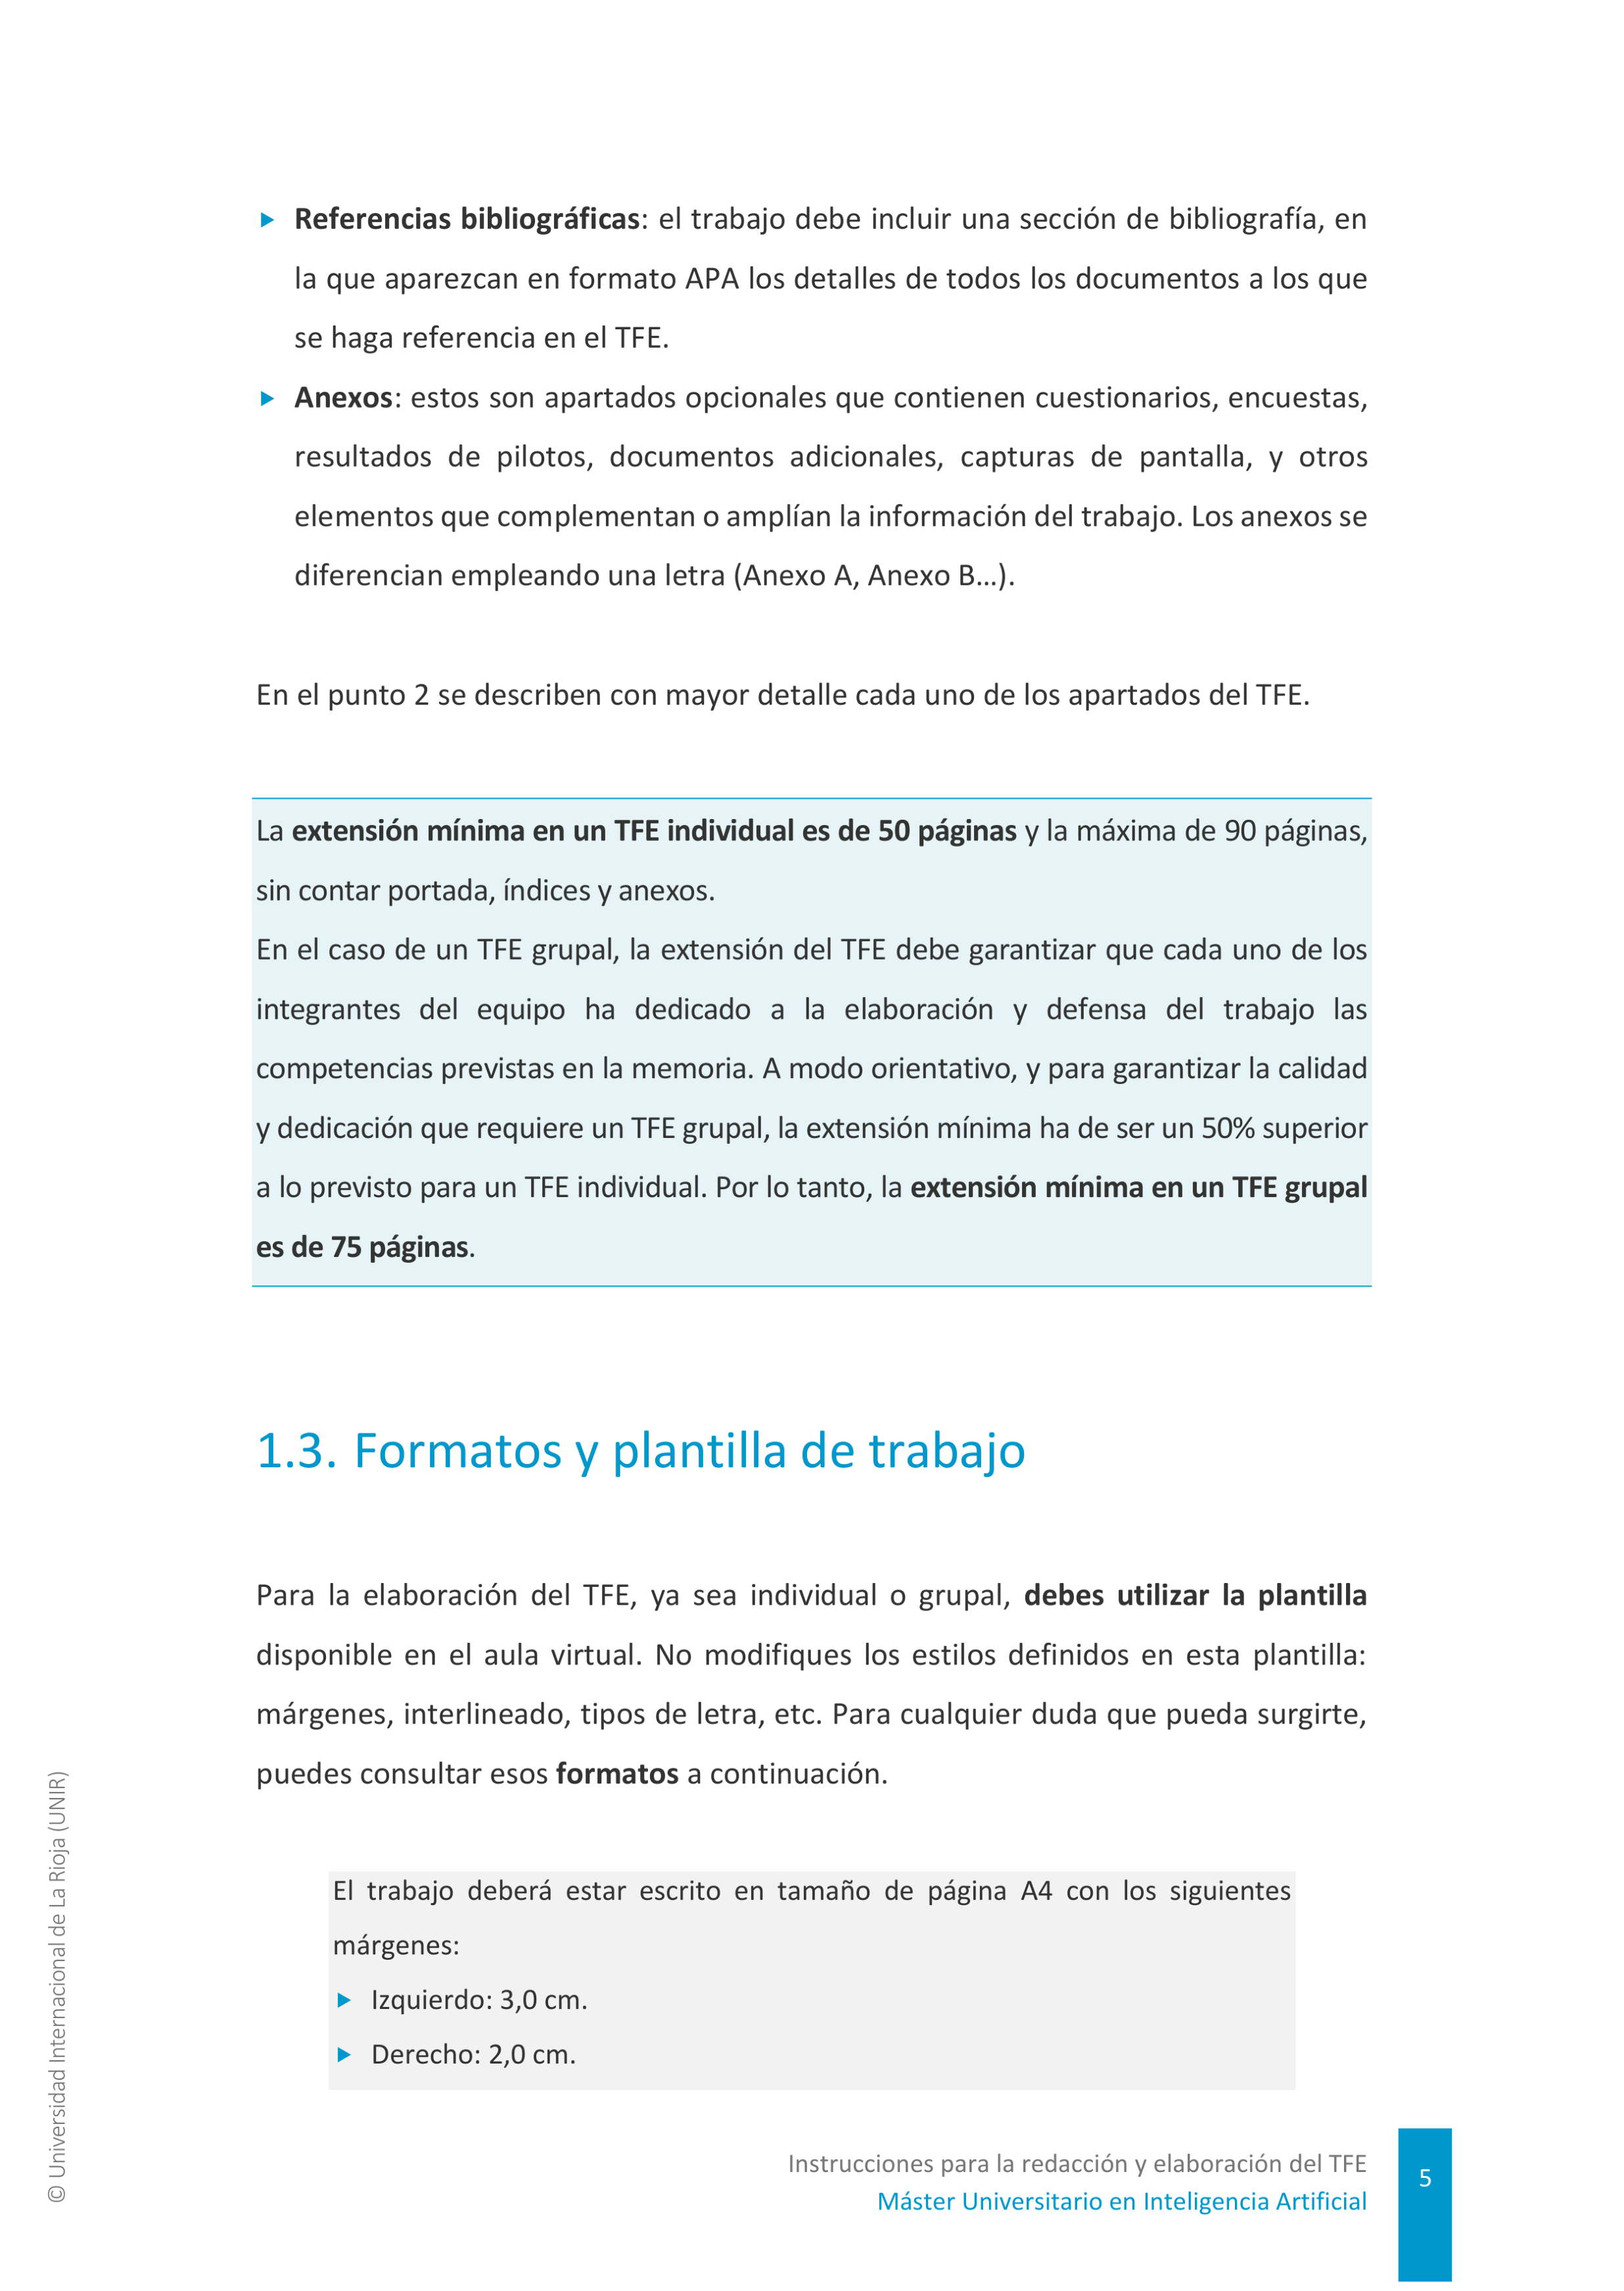

ref: 
Referencias bibliográficas: el trabajo debe incluir una sección de bibliografía, en
la que aparezcan en formato APA los detalles de todos los documentos a los que
se haga referencia en el TFE.
Anexos: estos son apartados opcionales que contienen cuestionarios, encuestas,
resultados de pilotos, documentos adicionales, capturas de pantalla, y otros
elementos que complementan o amplían la información del trabajo. Los anexos se
diferencian empleando una letra (Anexo A, Anexo B…).
En el punto 2 se describen con mayor detalle cada uno de los apartados del TFE.
La extensión mínima en un TFE individual es de 50 páginas y la máxima de 90 páginas,
sin contar portada, índices y anexos.
En el caso de un TFE grupal, la extensión del TFE debe garantizar que cada uno de los
integrantes del equipo ha dedicado a la elaboración y defensa del trabajo las
competencias previstas en la memoria. A modo orientativo, y para garantizar la calidad
y dedicación que requiere un TFE grupal, la extensión mínim

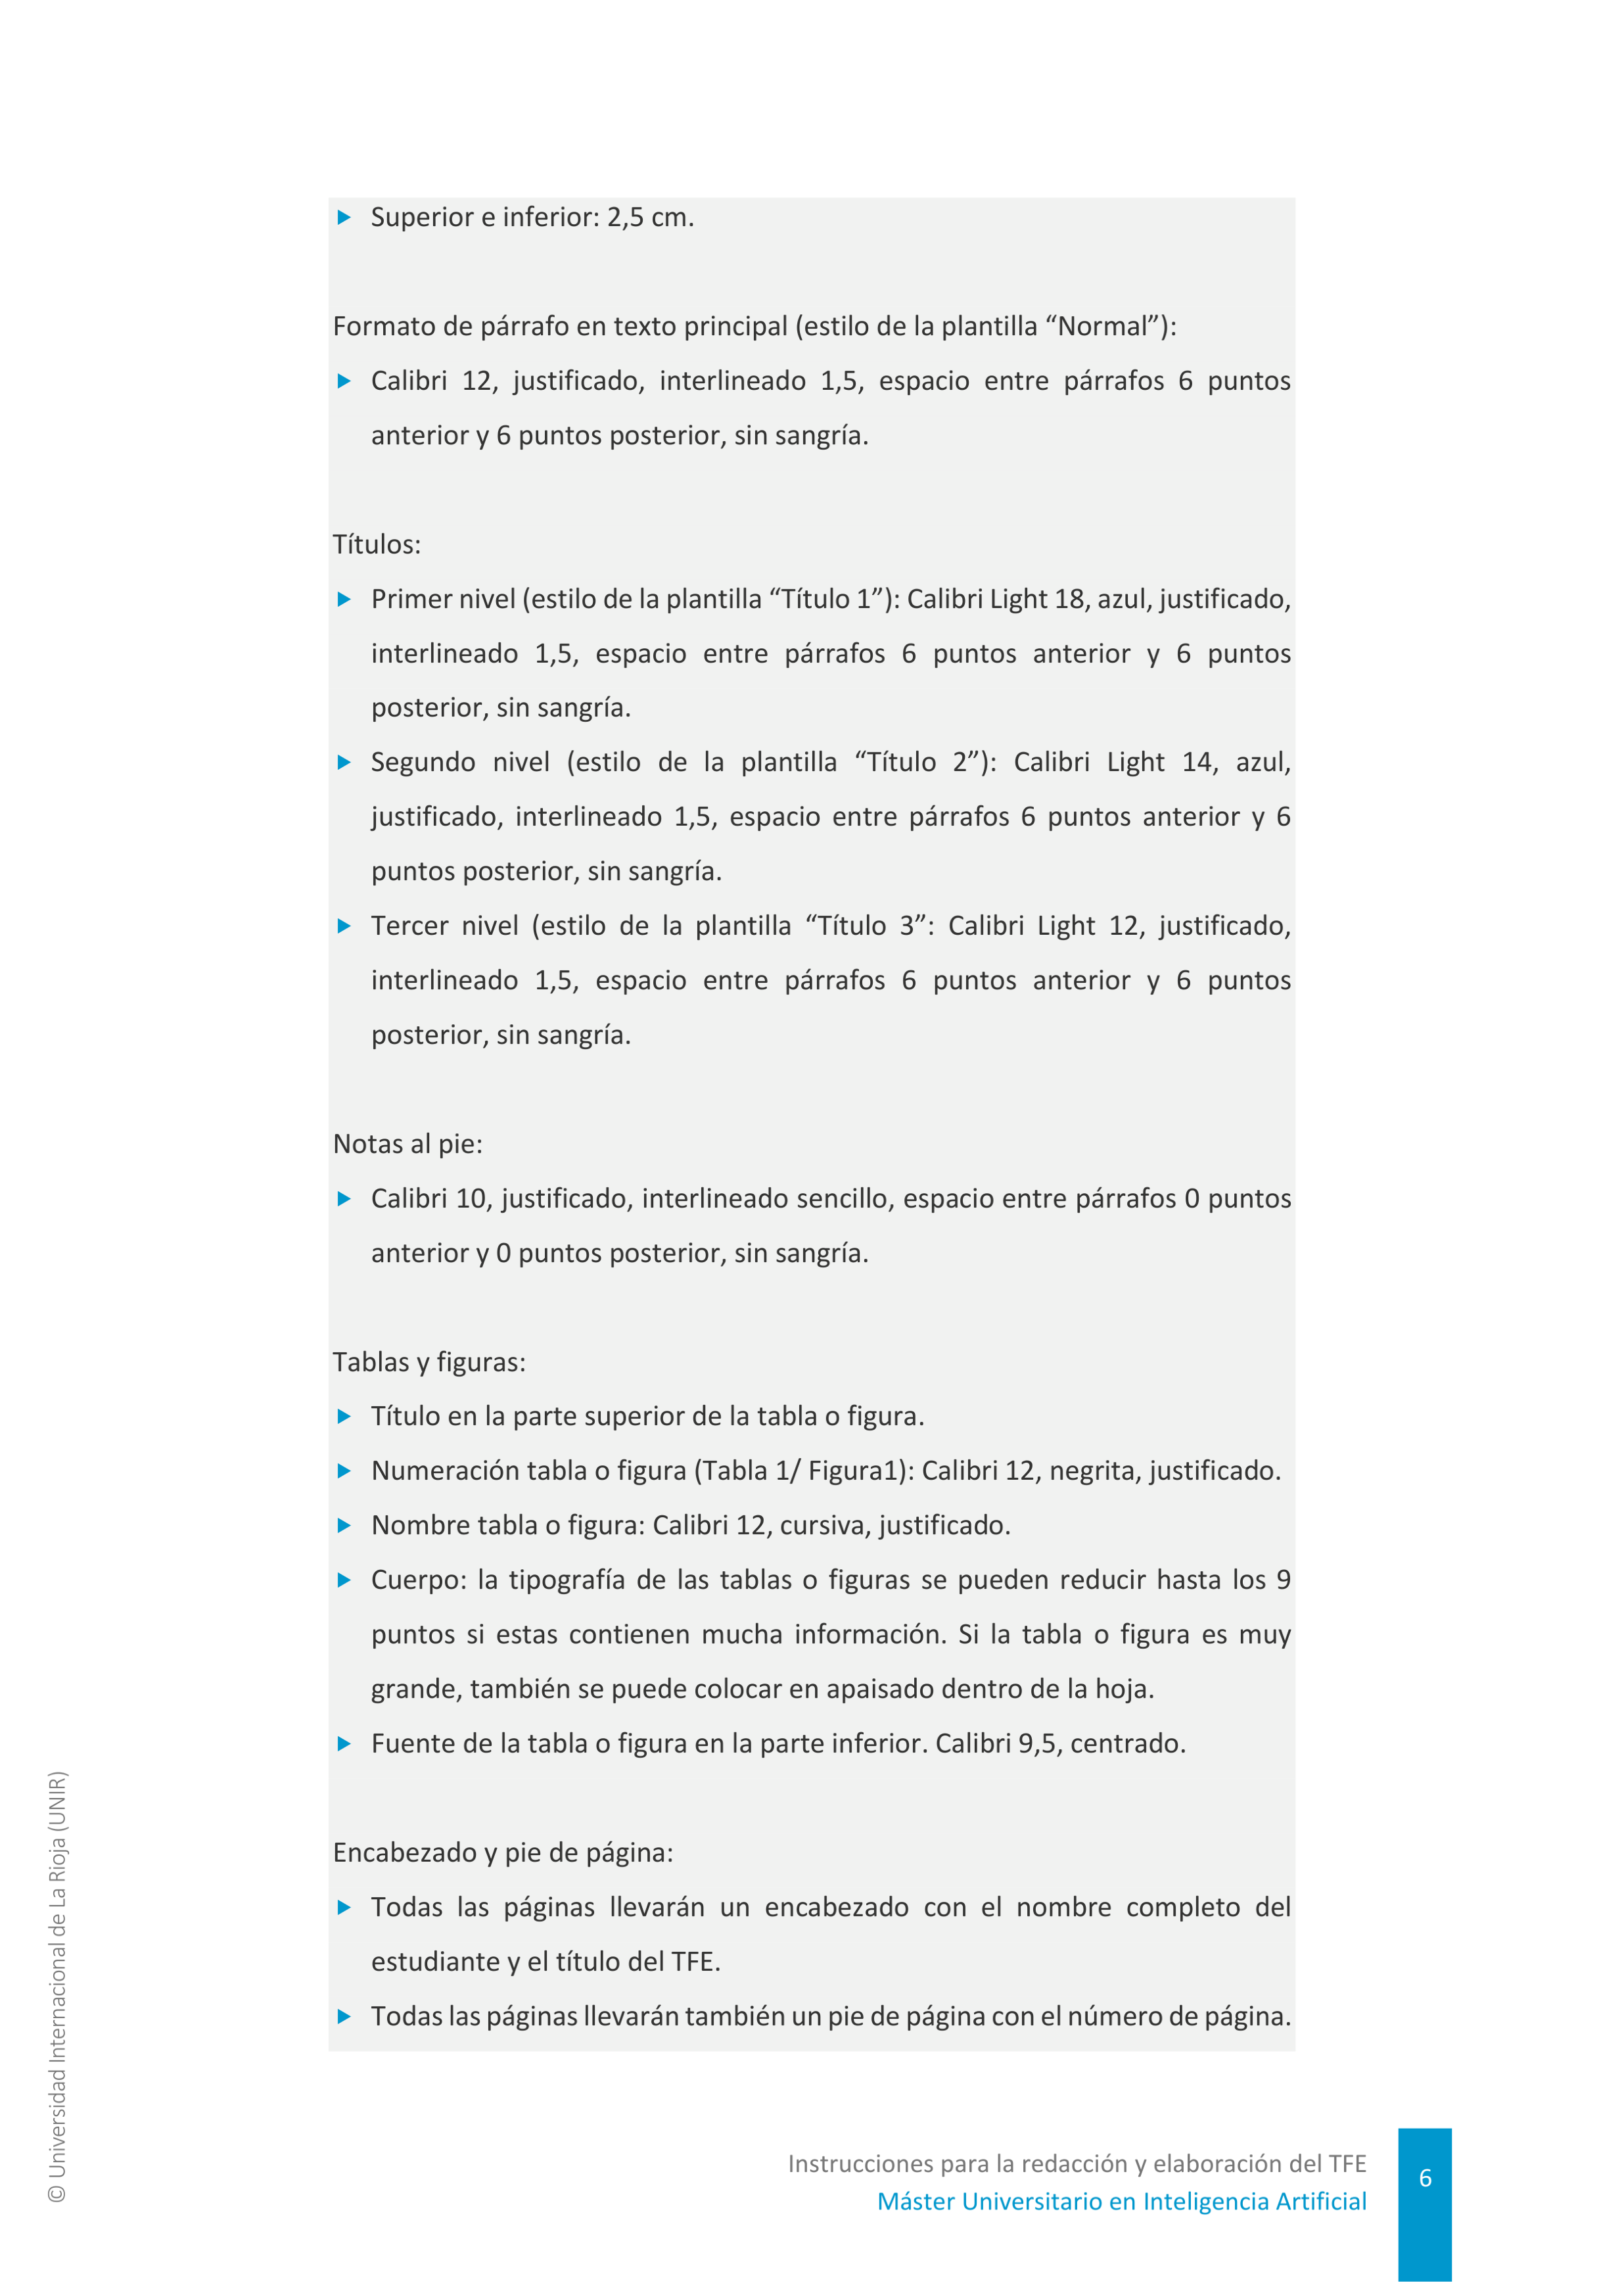

ref: 
Superior e inferior: 2,5 cm.
Formato de párrafo en texto principal (estilo de la plantilla “Normal”):
Calibri 12, justificado, interlineado 1,5, espacio entre párrafos 6 puntos
anterior y 6 puntos posterior, sin sangría.
Títulos:
Primer nivel (estilo de la plantilla “Título 1”): Calibri Light 18, azul, justificado,
interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos
posterior, sin sangría.
Segundo nivel (estilo de la plantilla “Título 2”): Calibri Light 14, azul,
justificado, interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6
puntos posterior, sin sangría.
Tercer nivel (estilo de la plantilla “Título 3”: Calibri Light 12, justificado,
interlineado 1,5, espacio entre párrafos 6 puntos anterior y 6 puntos
posterior, sin sangría.
Notas al pie:
Calibri 10, justificado, interlineado sencillo, espacio entre párrafos 0 puntos
anterior y 0 puntos posterior, sin sangría.
Tablas y figuras:
Título en la parte superior de la tabla o figura.
Numeración tabla o fi

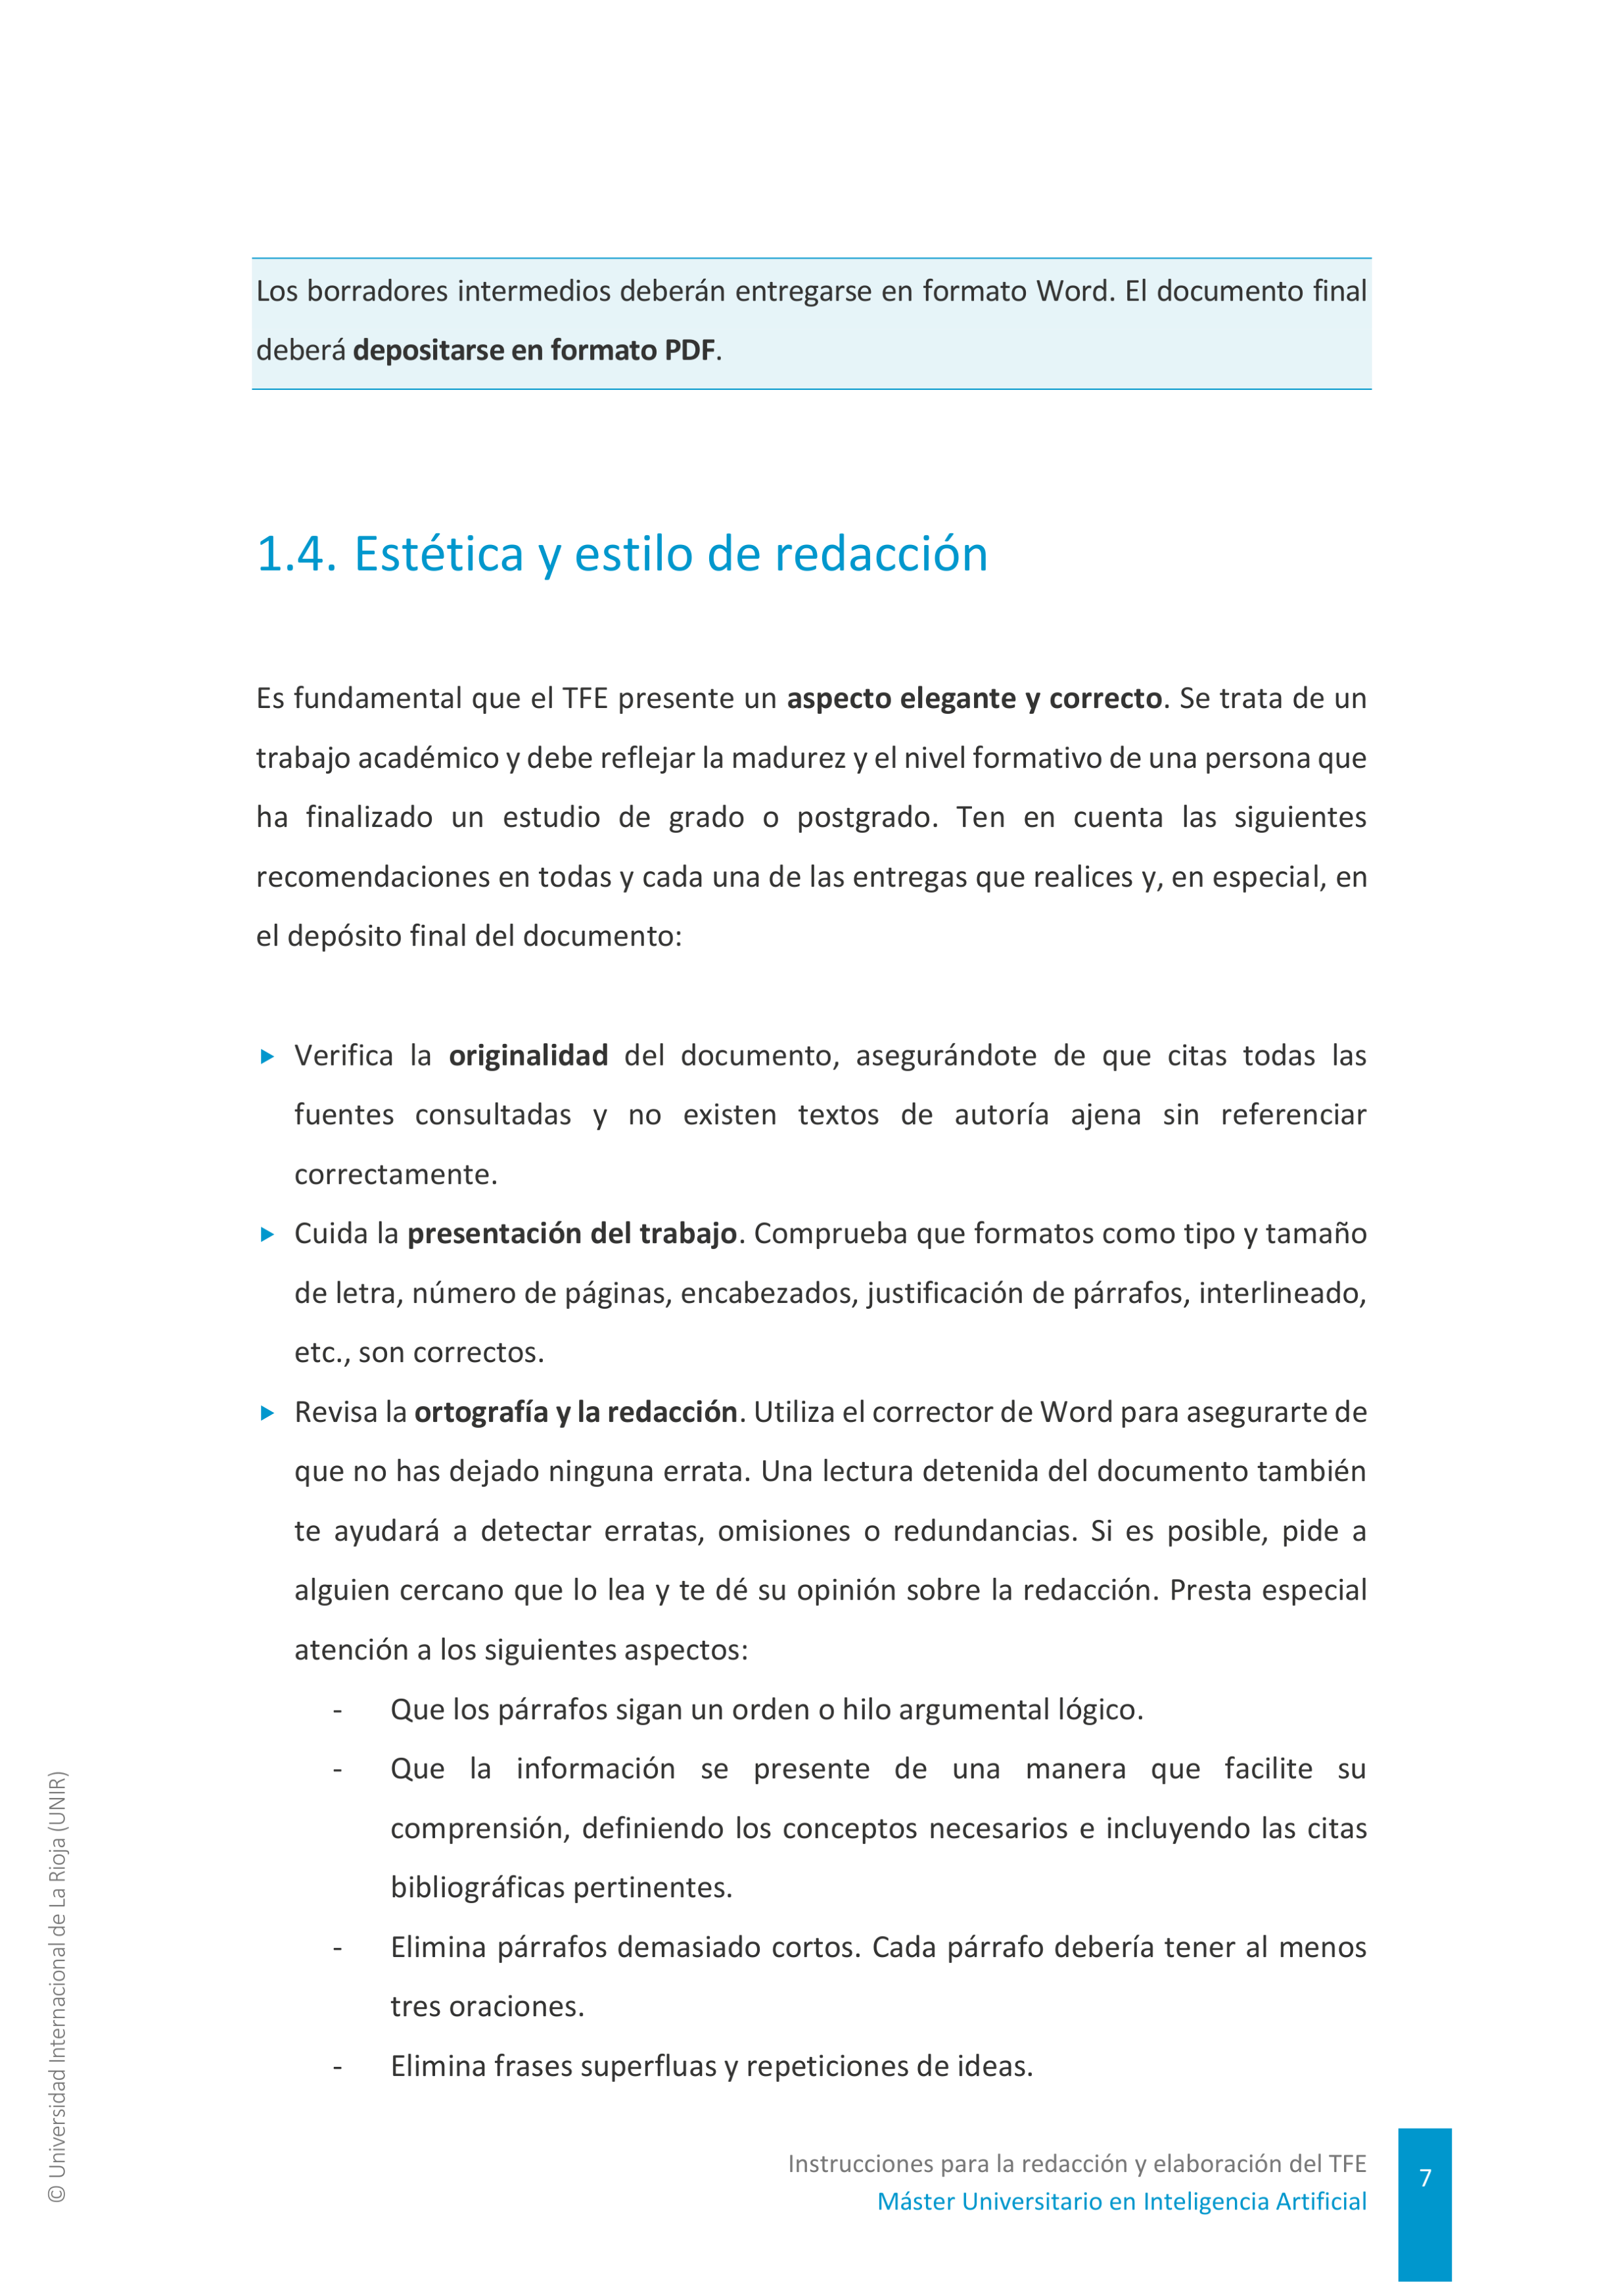

ref: 
Los borradores intermedios deberán entregarse en formato Word. El documento final
deberá depositarse en formato PDF.
1.4. Estética y estilo de redacción
Es fundamental que el TFE presente un aspecto elegante y correcto. Se trata de un
trabajo académico y debe reflejar la madurez y el nivel formativo de una persona que
ha finalizado un estudio de grado o postgrado. Ten en cuenta las siguientes
recomendaciones en todas y cada una de las entregas que realices y, en especial, en
el depósito final del documento:
Verifica la originalidad del documento, asegurándote de que citas todas las
fuentes consultadas y no existen textos de autoría ajena sin referenciar
correctamente.
Cuida la presentación del trabajo. Comprueba que formatos como tipo y tamaño
de letra, número de páginas, encabezados, justificación de párrafos, interlineado,
etc., son correctos.
Revisa la ortografía y la redacción. Utiliza el corrector de Word para asegurarte de
que no has dejado ninguna errata. Una lectura deten

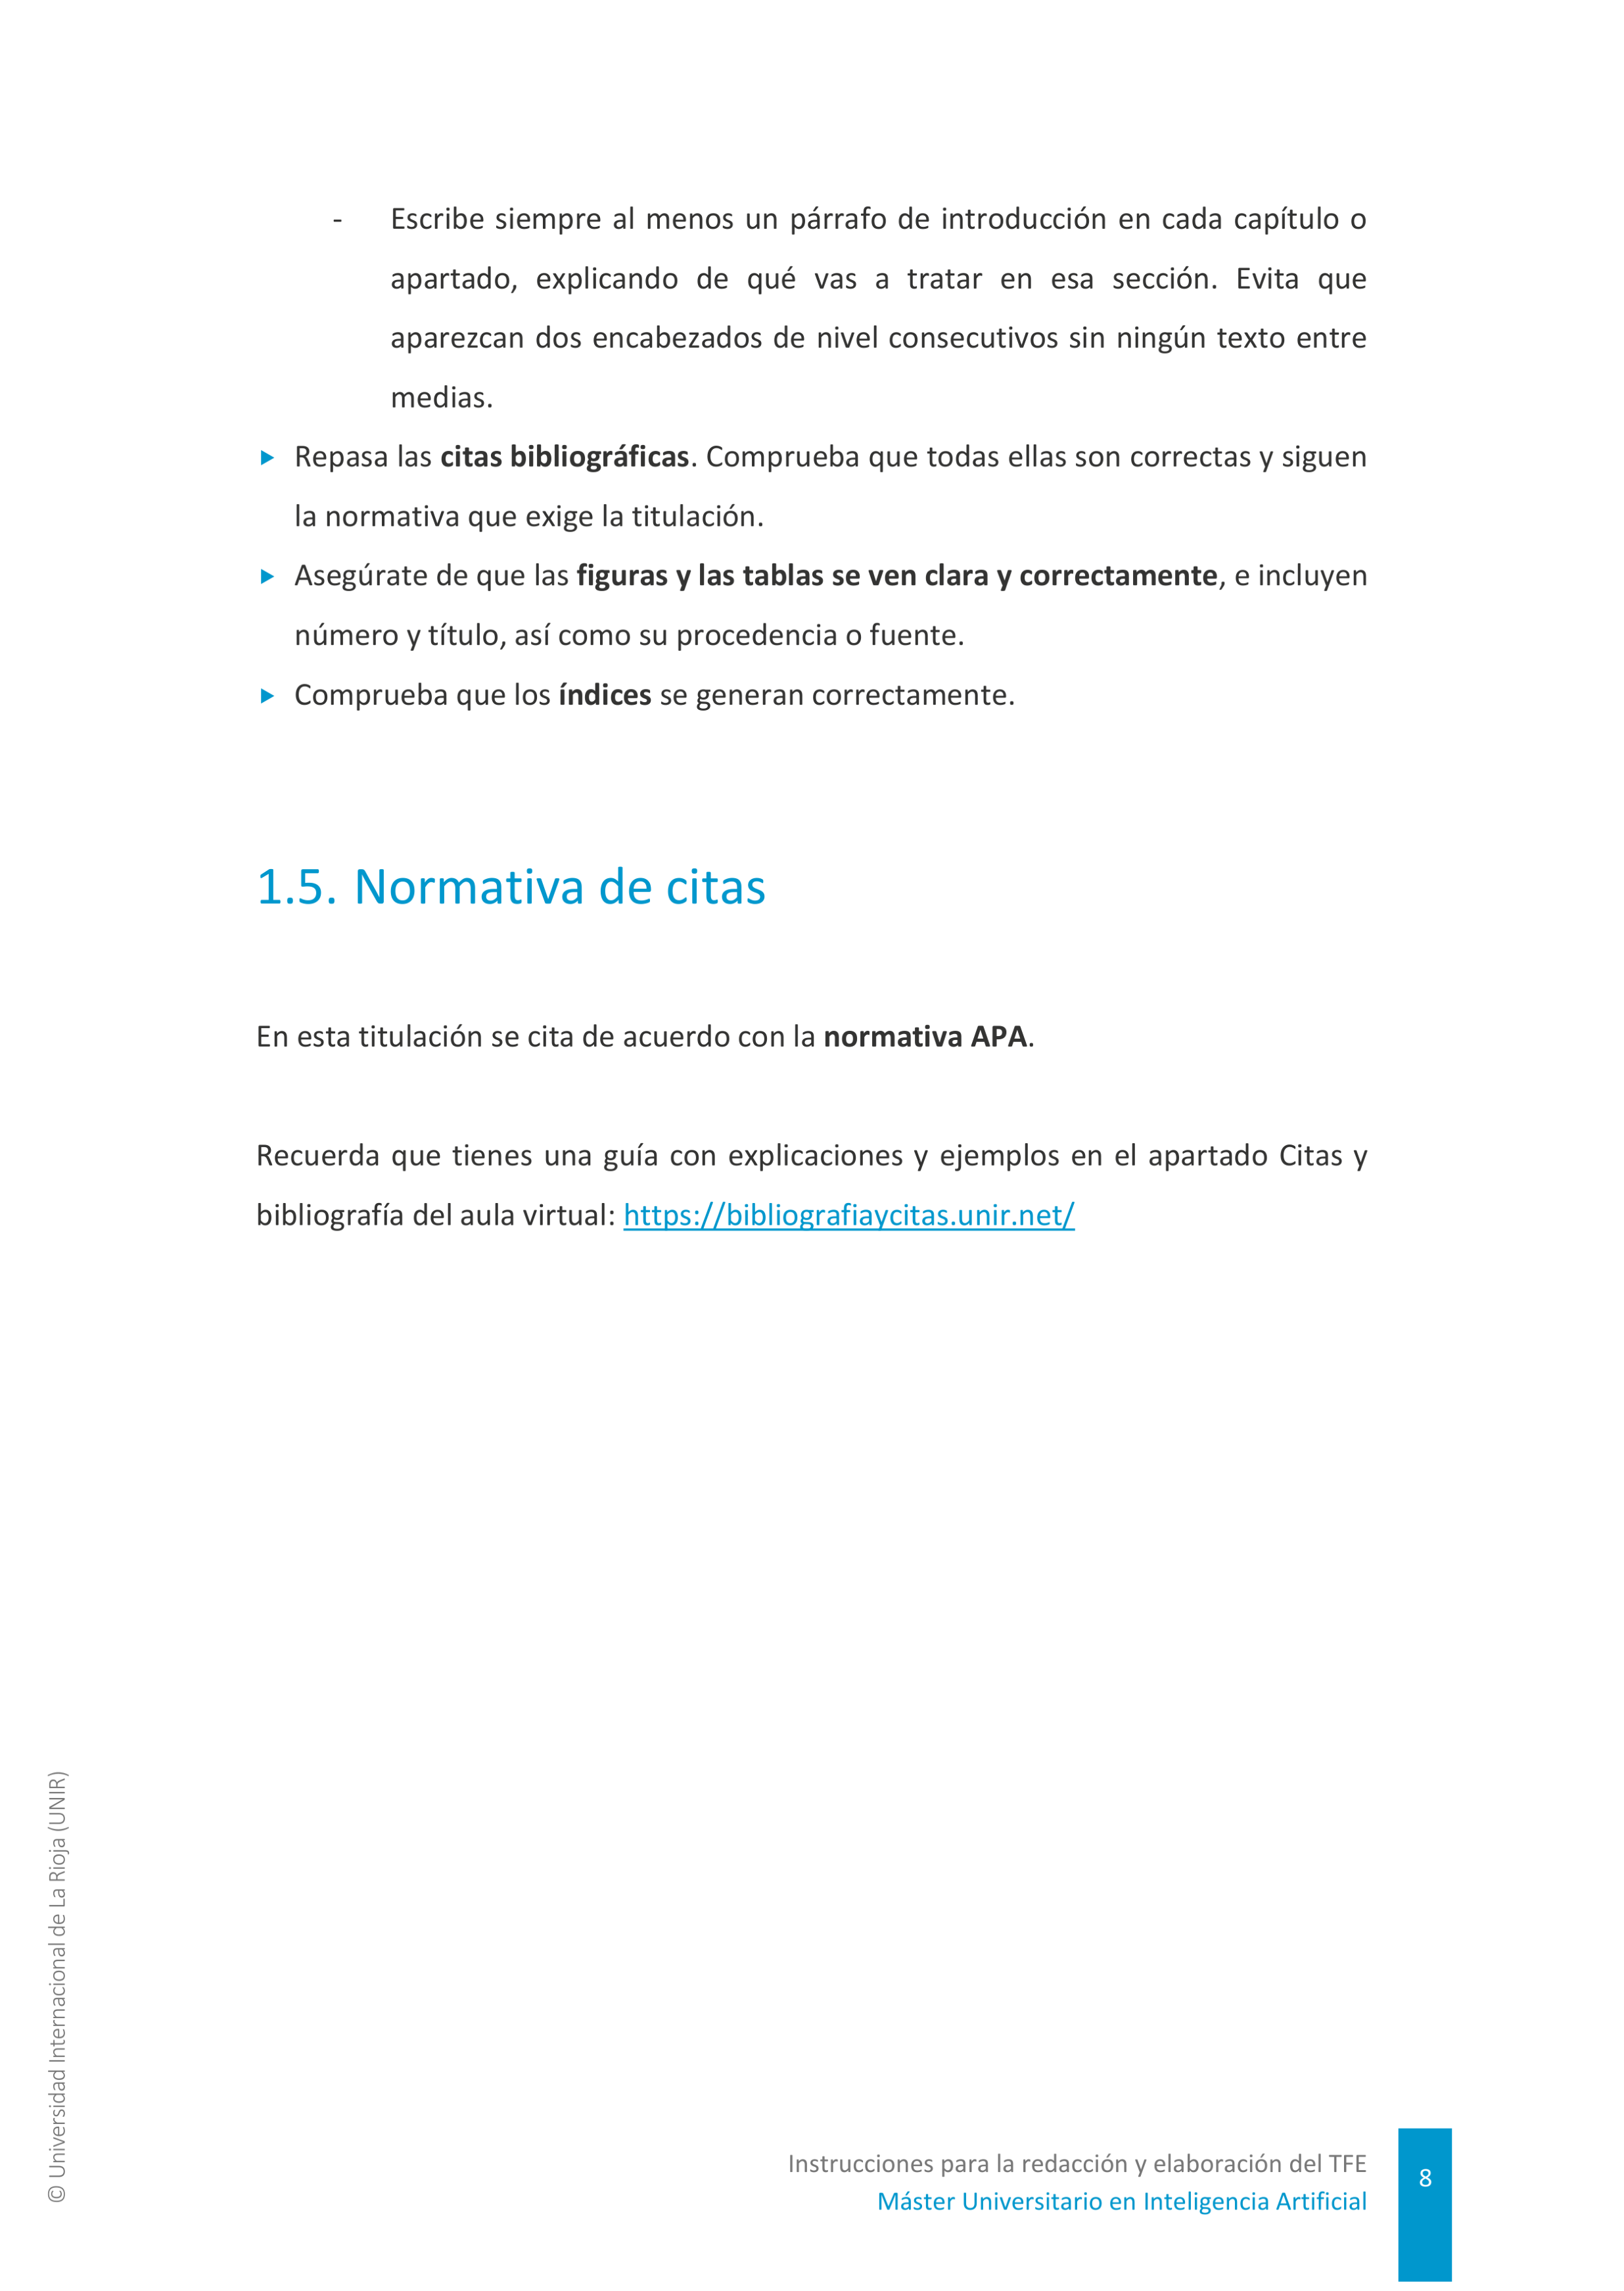

ref: 
-
Escribe siempre al menos un párrafo de introducción en cada capítulo o
apartado, explicando de qué vas a tratar en esa sección. Evita que
aparezcan dos encabezados de nivel consecutivos sin ningún texto entre
medias.
Repasa las citas bibliográficas. Comprueba que todas ellas son correctas y siguen
la normativa que exige la titulación.
Asegúrate de que las figuras y las tablas se ven clara y correctamente, e incluyen
número y título, así como su procedencia o fuente.
Comprueba que los índices se generan correctamente.
1.5. Normativa de citas
En esta titulación se cita de acuerdo con la normativa APA.
Recuerda que tienes una guía con explicaciones y ejemplos en el apartado Citas y
bibliografía del aula virtual: https://bibliografiaycitas.unir.net/
© Universidad Internacional de La Rioja (UNIR)
Instrucciones para la redacción y elaboración del TFE
8
Máster Universitario en Inteligencia Artificial
paddle_text: 
Escribe siempre al menos un párrafo de introducción en cada capítulo o


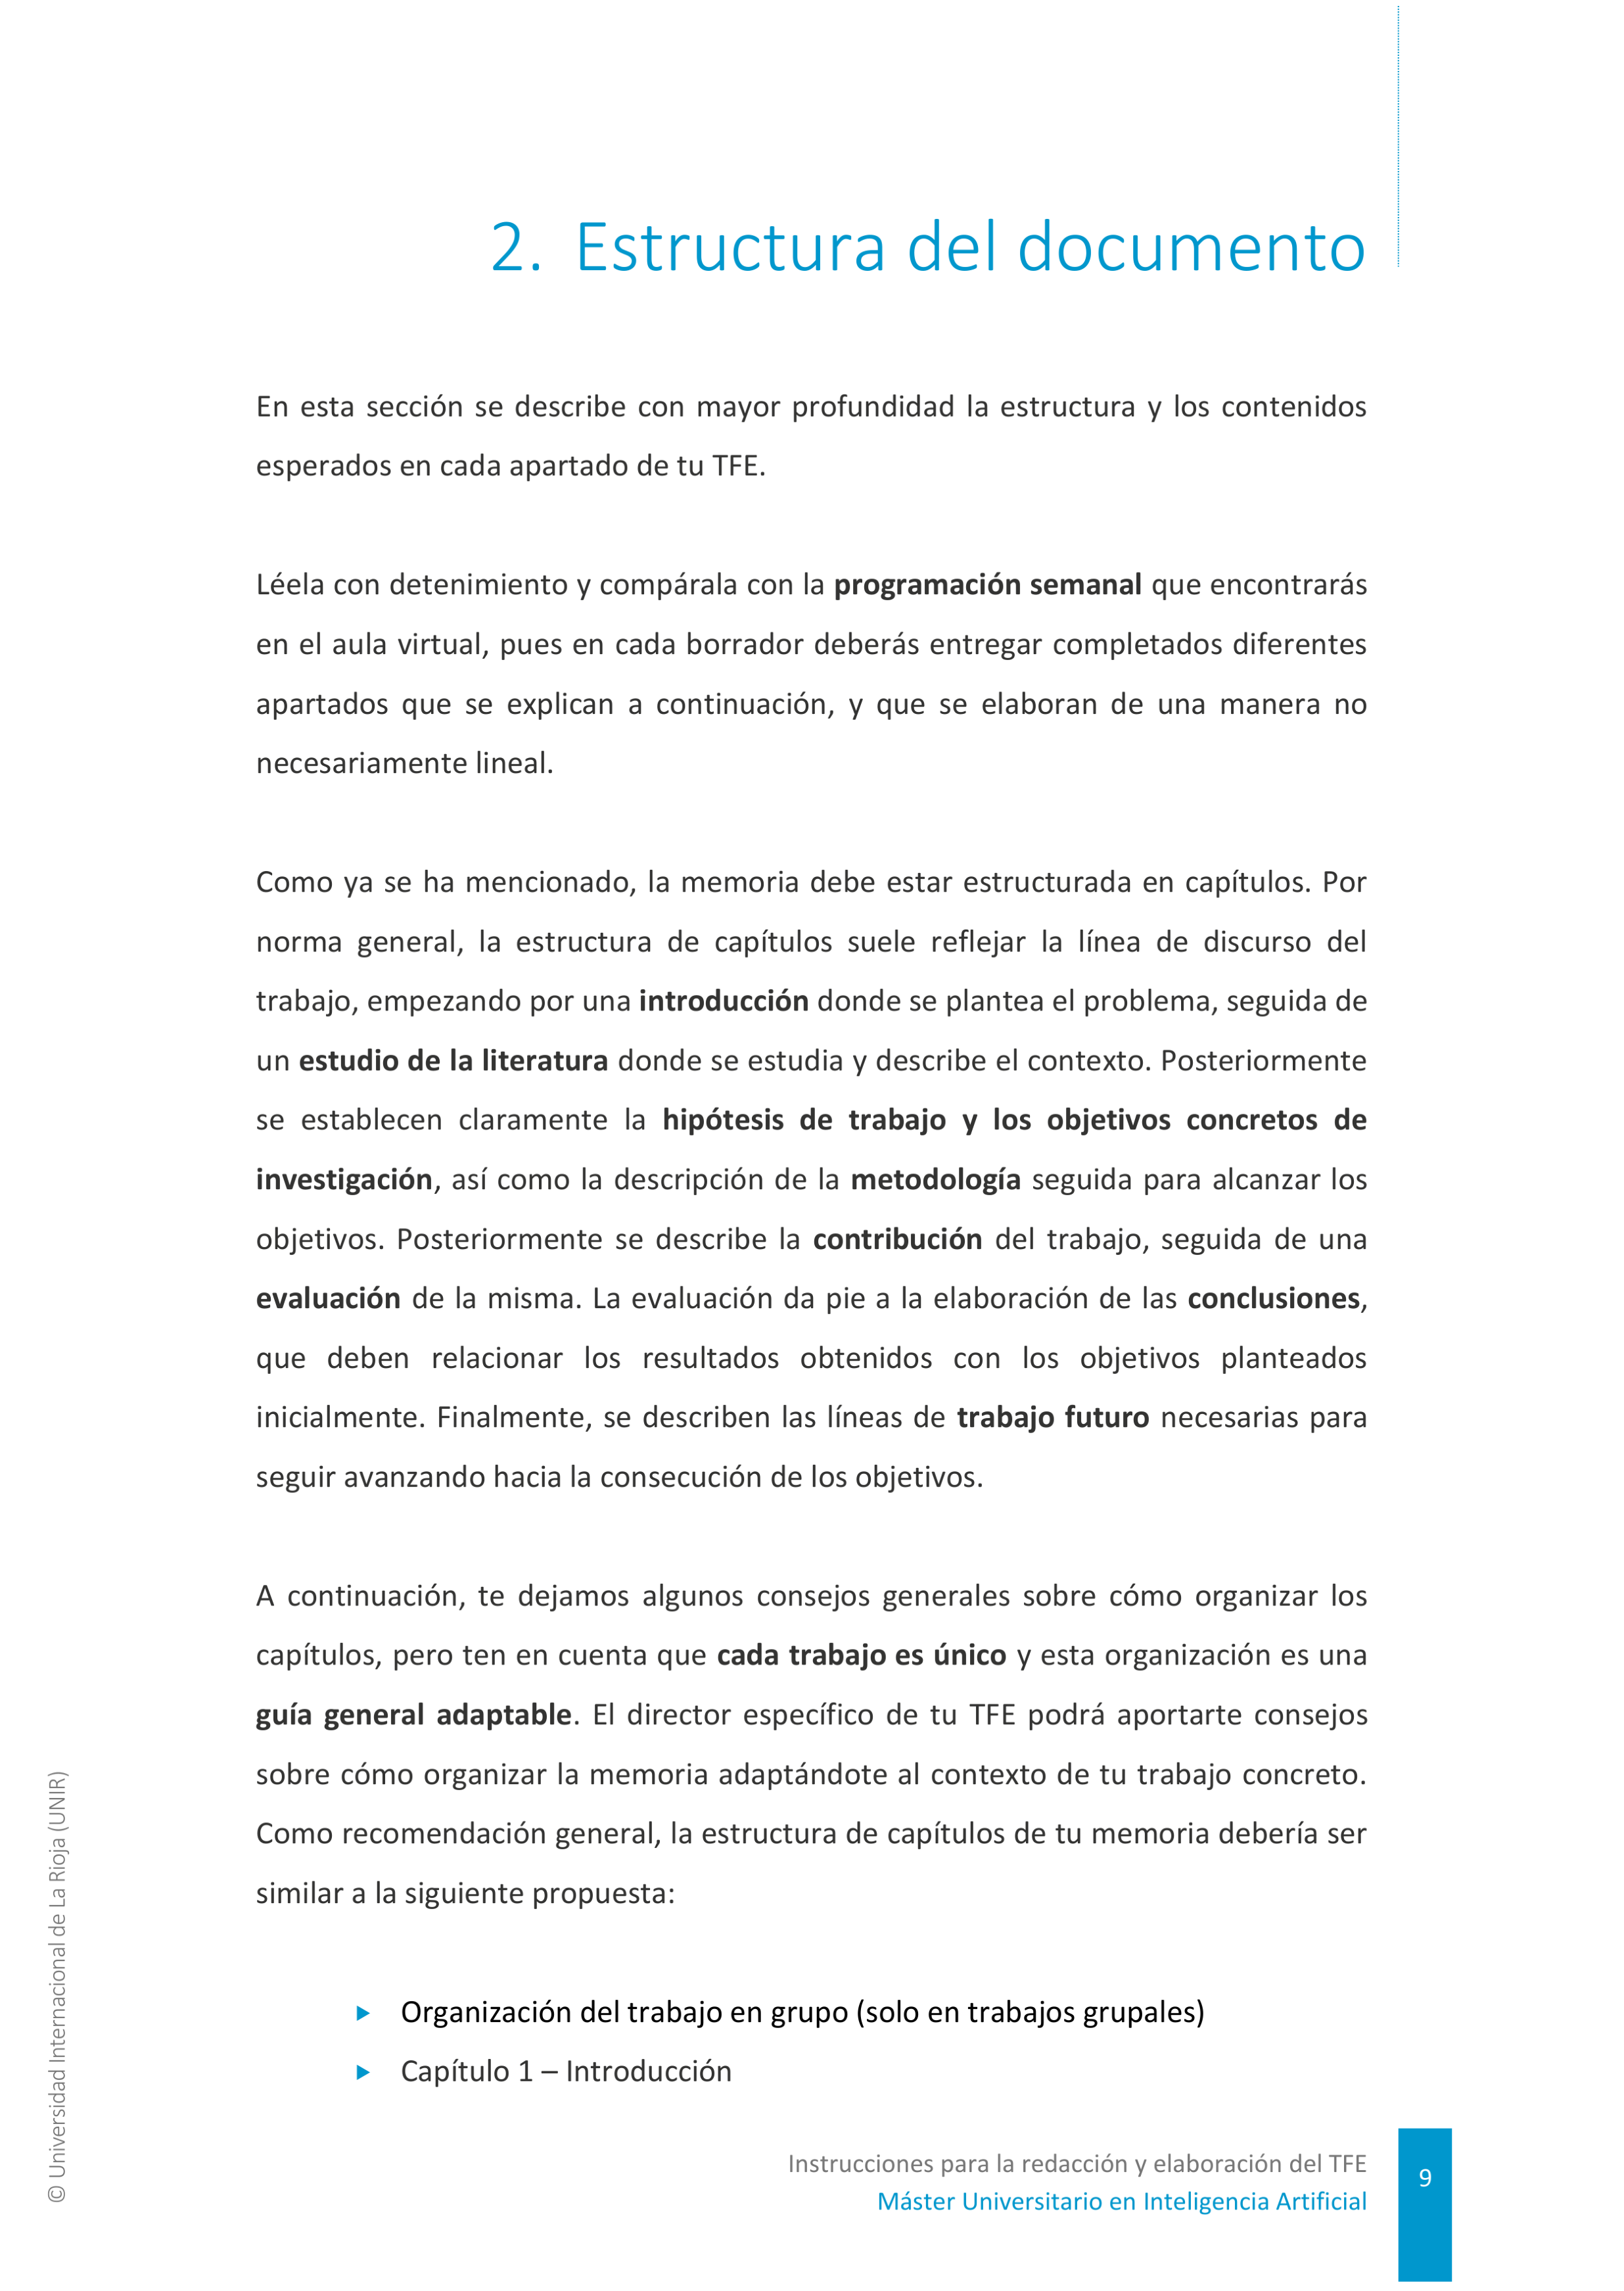

ref: 
2. Estructura del documento
En esta sección se describe con mayor profundidad la estructura y los contenidos
esperados en cada apartado de tu TFE.
Léela con detenimiento y compárala con la programación semanal que encontrarás
en el aula virtual, pues en cada borrador deberás entregar completados diferentes
apartados que se explican a continuación, y que se elaboran de una manera no
necesariamente lineal.
Como ya se ha mencionado, la memoria debe estar estructurada en capítulos. Por
norma general, la estructura de capítulos suele reflejar la línea de discurso del
trabajo, empezando por una introducción donde se plantea el problema, seguida de
un estudio de la literatura donde se estudia y describe el contexto. Posteriormente
se establecen claramente la hipótesis de trabajo y los objetivos concretos de
investigación, así como la descripción de la metodología seguida para alcanzar los
objetivos. Posteriormente se describe la contribución del trabajo, seguida de una
evaluación de la 

In [11]:
results = []

for pdf_file in os.listdir(PDF_FOLDER):
    if not pdf_file.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    page_range = range(5, 10)
    
    images = pdf_to_images(pdf_path, 300, page_range)
    
    for i, img in enumerate(images):
        # img = preprocess_for_ocr(img)
        page_num = page_range[i]
        ref = pdf_extract_text(pdf_path, page_num=page_num)
        show_page(img, f"page: {page_num}", 1)
        print(f"ref: \n{ref}")
        
        # Convert PIL image to numpy array
        image_array = np.array(img)
        
        # PaddleOCR
        paddle_text = ocr_paddle(img, image_array)
        print(f"paddle_text: \n{paddle_text}")
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'PaddleOCR', 'Prediction': paddle_text, **evaluate_text(ref, paddle_text)})
        

## 5 Save and Analyze Results

Benchmark results saved as ai_ocr_benchmark_finetune_results_20251112_095108.csv
                WER       CER
Model                        
PaddleOCR  0.109534  0.052167


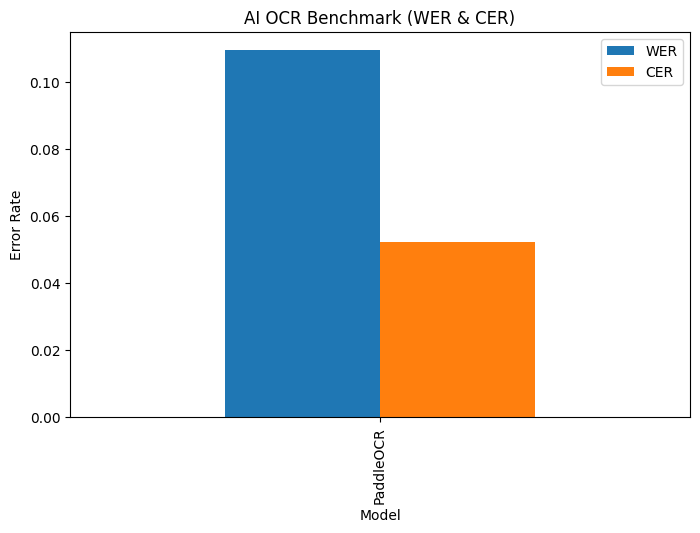

In [12]:
df_results = pd.DataFrame(results)

# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"ai_ocr_benchmark_finetune_results_{timestamp}.csv"
filepath = os.path.join(OUTPUT_FOLDER, filename)

df_results.to_csv(filepath, index=False)
print(f"Benchmark results saved as {filename}")

# Summary by model
summary = df_results.groupby('Model')[['WER', 'CER']].mean()
print(summary)

# Plot
summary.plot(kind='bar', figsize=(8,5), title='AI OCR Benchmark (WER & CER)')
plt.ylabel('Error Rate')
plt.show()

### How to read this chart:
- CER (Character Error Rate) focus on raw transcription quality
- WER (Word Error Rate) penalizes incorrect tokenization or missing spaces
- CER and WER are error metrics, which means:
    - Higher values = worse performance
    - Lower values = better accuracy

### Compared solutions
| Model                  | Type                         | Components                   | Key Strengths                                              | Why It Matters                                           |
| :--------------------- | :--------------------------- | :--------------------------- | :--------------------------------------------------------- | :------------------------------------------------------- |
| **EasyOCR**            | End-to-end (det + rec)       | DB + CRNN/Transformer        | Lightweight, easy to run, multilingual                     | Serves as *baseline neuronal* (fast & reproducible).     |
| **PaddleOCR (PP-OCR)** | End-to-end (det + rec + cls) | DB + SRN/CRNN                | Strong multilingual support, configurable pipeline         | Industrial reference; widely benchmarked.                |
| **DocTR**              | End-to-end (det + rec)       | DB/LinkNet + CRNN/SAR/VitSTR | Research-oriented, clean API, high-level structured output | Represents the latest *PyTorch*-based academic approach. |


These cover the three major open-source paradigms for deep OCR:

EasyOCR: compact CRNN-based recognizer.

PaddleOCR: large industrial model (PP-OCR family).

DocTR: modular research library from Mindee, built for experimentation.

Together they already let you analyse:

accuracy (CER/WER),

inference latency,

model architecture trade-offs.